<a href="https://colab.research.google.com/github/alexc6h6/Generative-Adversarial-Networks/blob/master/FC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model



In [11]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!ls '/content/drive/My Drive/digit_recognizer'

MNIST_model.h5	sample_submission.csv  test.csv  train.csv


In [0]:
data = pd.read_csv('/content/drive/My Drive/digit_recognizer/train.csv')

In [14]:
images = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
images = (images.astype('float32')-127.5)/127.5

print(images.shape)


(42000, 28, 28, 1)


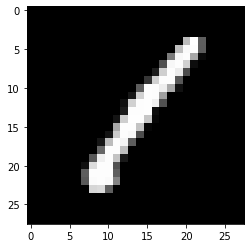

In [15]:
plt.imshow(images[0, :, :, 0], cmap = 'gray')

In [16]:
images = images.reshape(-1, images.shape[1]*images.shape[2]*images.shape[3])

print(images.shape)

(42000, 784)


In [17]:
42000/3750

11.2

In [0]:
noise_dim = 100
img_row, img_col, img_chan = 28, 28, 1
adam = Adam(learning_rate = 0.0002, beta_1 = 0.5)  ###
epochs = 20
steps_per_epoch = 3750
batch_size = 32

In [0]:
def create_generator():
  generator = Sequential(name = 'generator')

  generator.add(Dense(256, input_dim = noise_dim))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))  
  generator.add(LeakyReLU(0.2))

  generator.add(Dense(img_row * img_col * img_chan, activation = 'tanh'))

  generator.compile(optimizer = adam, loss = 'binary_crossencropy')

  return generator

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)               80

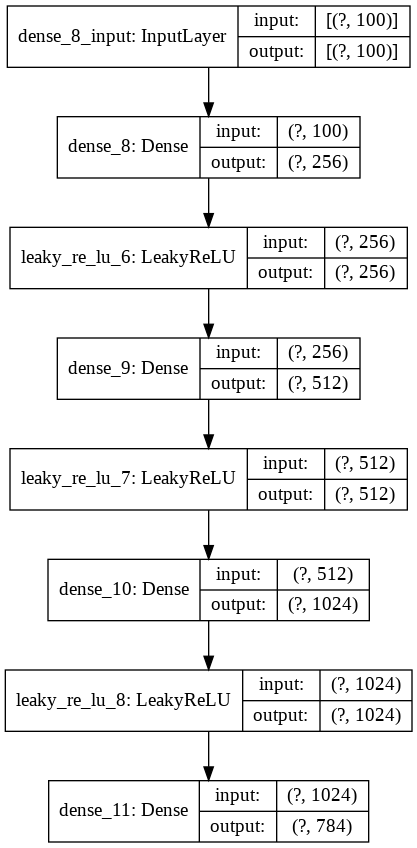

In [29]:
generator = create_generator()
generator.summary()
plot_model(generator, show_shapes = True)


In [0]:
def create_discriminator():
  discriminator = Sequential(name = 'discriminator')

  discriminator.add(Dense(1024, input_dim = img_row * img_col * img_chan))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(1, activation = 'sigmoid'))

  discriminator.compile(optimizer = adam, loss = 'binary_crossentropy')

  return discriminator

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

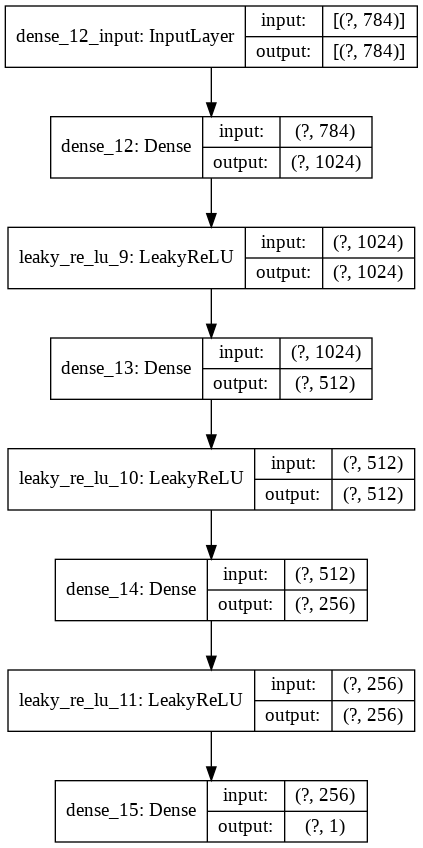

In [31]:
discriminator = create_discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes = True)

Model: "gan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1486352   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


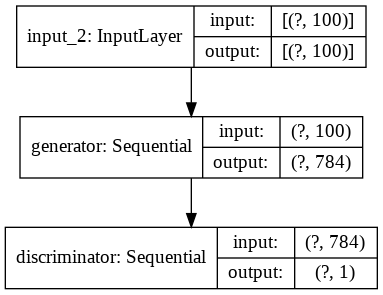

In [32]:
discriminator.trainable = False

gan_input = Input(shape = (noise_dim, ))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)

gan = Model(gan_input, gan_output, name = 'gan_model')

gan.summary()
plot_model(gan, show_shapes = True)

In [0]:
gan.compile(optimizer = adam, loss = 'binary_crossentropy')


In [34]:
for epoch in range(epochs):
  for batch in range(steps_per_epoch):
    noise = np.random.normal(0, 1, size = (batch_size, noise_dim))
    
    fake_x = generator.predict(noise)
    real_x = images[np.random.randint(0, images.shape[0], size = batch_size)]
    x = np.concatenate((real_x, fake_x))

    disc_y = np.zeros(2* batch_size)
    disc_y[:batch_size] = 0.9   #label smoothing

    discriminator_loss = discriminator.train_on_batch(x, disc_y)

    gan_y = np.ones(batch_size)
    gan_loss = gan.train_on_batch(noise, gan_y)

  print(f'Epoch: {epoch} \t Discriminator Loss: {discriminator_loss} \t Gan Loss: {gan_loss}')


Epoch: 0 	 Discriminator Loss: 0.5650482177734375 	 Gan Loss: 1.352769136428833
Epoch: 1 	 Discriminator Loss: 0.5990903377532959 	 Gan Loss: 1.3129950761795044
Epoch: 2 	 Discriminator Loss: 0.5170438289642334 	 Gan Loss: 1.659193992614746
Epoch: 3 	 Discriminator Loss: 0.5516883730888367 	 Gan Loss: 1.4203858375549316
Epoch: 4 	 Discriminator Loss: 0.5277611613273621 	 Gan Loss: 1.7829980850219727
Epoch: 5 	 Discriminator Loss: 0.5359832048416138 	 Gan Loss: 1.811002492904663
Epoch: 6 	 Discriminator Loss: 0.5184329748153687 	 Gan Loss: 1.7682175636291504
Epoch: 7 	 Discriminator Loss: 0.5394689440727234 	 Gan Loss: 1.440598487854004
Epoch: 8 	 Discriminator Loss: 0.5043765306472778 	 Gan Loss: 1.657158374786377
Epoch: 9 	 Discriminator Loss: 0.5957788228988647 	 Gan Loss: 1.4842976331710815
Epoch: 10 	 Discriminator Loss: 0.6057643294334412 	 Gan Loss: 1.6999129056930542
Epoch: 11 	 Discriminator Loss: 0.48622775077819824 	 Gan Loss: 1.5584371089935303
Epoch: 12 	 Discriminator Loss

In [0]:
def show_image(noise):
  generated_img = generator.predict(noise)

  plt.figure(figsize = (20, 20))

  for i, image in enumerate(generated_img):
    plt.subplot(10, 10, i+1)
    plt.imshow(image.reshape(28, 28), cmap = 'gray')
    plt.axis('off')

  #plt.tight_layout()
  plt.show()

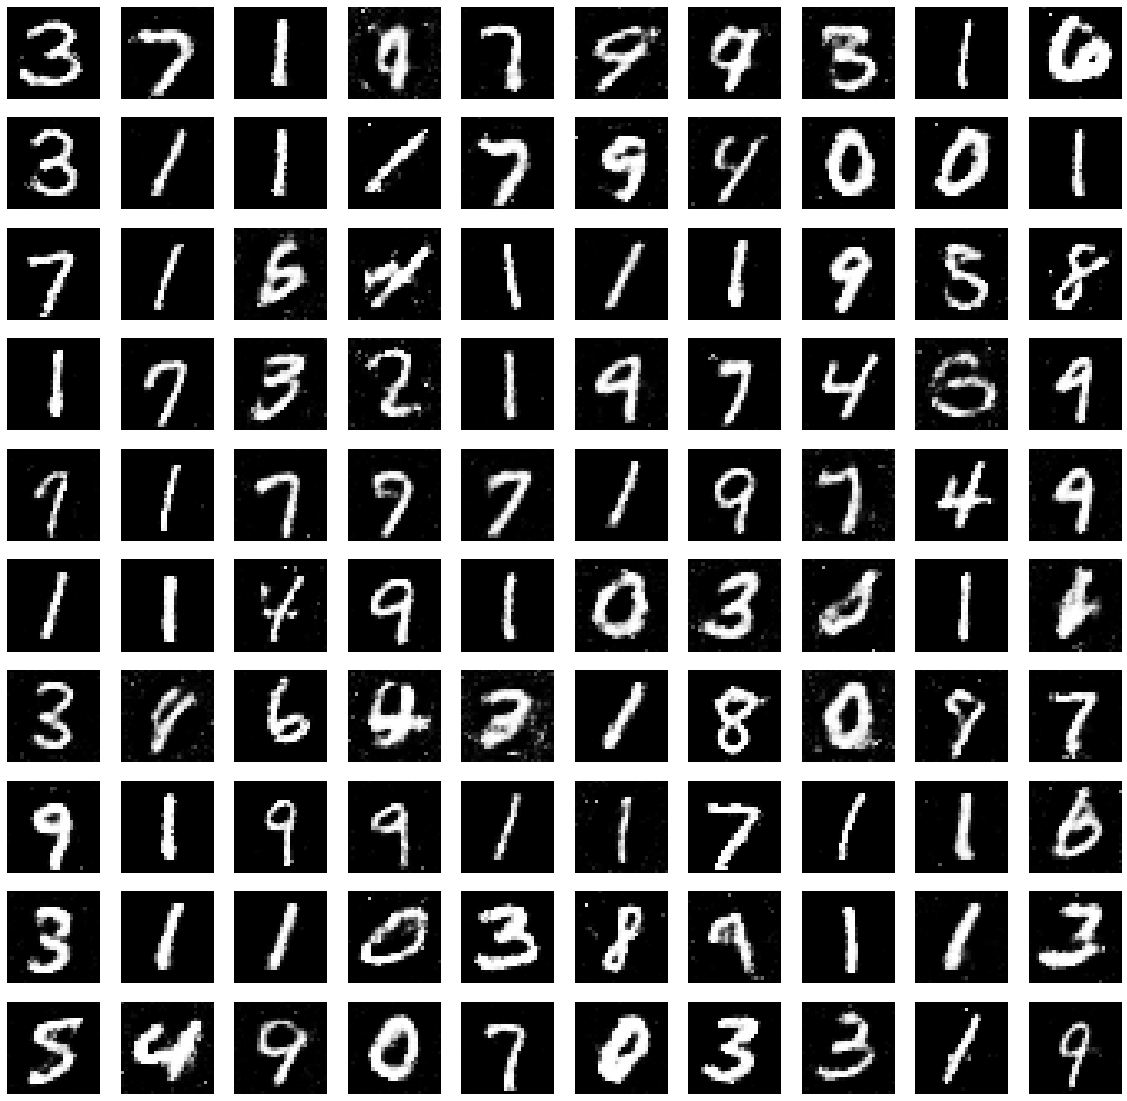

In [37]:
test_noise = np.random.normal(0, 1, size = (100, noise_dim))
show_image(test_noise)